## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples\\chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages

# import inp_data_extractor.py as inp:
try:
    import inp_data_extractor as inp
except ImportError:
    try:
        from Bubble_dynamics_simulation import inp_data_extractor as inp
    except ImportError as error:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
        raise error
    except Exception as error:
        print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
        raise error
except Exception as error:
    print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
    raise error
importlib.reload(inp)   # reload changes you made

# create parameters.py
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import numpy as np   # matrices, math
import time   # runtime measurement
import os    # file management
import pandas as pd   # data frames
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# import gradient_descent.py as gd:
_already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except ImportError:
    try:
        from  Bubble_dynamics_simulation import gradient_descent as gd
    except ImportError as _error:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
        raise _error
    except Exception as _error:
        print(colored(f'Error, \'gradient_descent.py\' failed to load', 'red'))
        raise _error
except Exception as _error:
    print(colored(f'Error, \'gradient_descent.py\' failed to load', 'red'))
    raise _error
if _already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Ranges, settings

In [3]:
# Control parameter ranges
# make sure, it's only 2D

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1e-6*x for x in [5.0, 125.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [20.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    # vapour pressure [Pa]
    #P_v = par.P_v, # calculated from T_inf
    # dynamic viscosity [Pa*s]
    #mu_L = par.mu_L, # calculated from T_inf
    # density [kg/m^3]
    rho_L =  [998.20],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = sin_impulse)
    # excitation amplitude [Pa]
    p_A = [-x * par.bar2Pa for x in [1.0, 3.0]], # [bar --> Pa]
    # excitation frequency [Hz]
    freq =  [20000.00],
    # excitation duration in period times [-]
    n =  [1.00],
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

examined_keys = []
for key in ranges:
    if len(ranges[key]) > 1:
        examined_keys.append(key)

print(f'The following control parameters will be examined: {examined_keys}')
if len(examined_keys) != 2:
    print(colored(f'Error, exactly 2 control parameters have to be examined', 'red'))
key1 = examined_keys[0]
key2 = examined_keys[1]

The following control parameters will be examined: ['R_E', 'p_A']


In [4]:
# Settings:
to_optimize = 'energy_demand'   # key in data from de.get_data()
directory = 'test_1atm_20000Hz_2D'   # appropiate 2D bruteforce parameter study
file_base_name = 'output_'

## Reading files, 2D contour plot
This is optional, you don't have to place a contour plot underneath the gadient descent visualization.
The bruteforce param study should be 2D with the same range as above, and uniform spacement.

In [5]:
# create a dataframe
all_data = pd.DataFrame()
num = 0

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))

        # Cast object-dtype columns with all-bool values to bool dtype
        for col in current_data.columns:
            if current_data[col].dtype == 'object' and all(current_data[col].dropna().map(lambda x: isinstance(x, bool))):
                current_data[col] = current_data[col].astype(bool)

                
        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])

# locate successful simulations (or use all_data['success'] == True)
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_demand'] > 0.0) & (all_data['energy_demand'] == all_data['energy_demand']) # positive not NaN
]

good_data = good_data.sort_values(['ID'], ascending=True)
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

	output_1.csv             (1001 rows)
	output_2.csv             (1001 rows)
	output_3.csv             ( 498 rows)
Good data: 2457 rows ( 98.28 %)


In [6]:
# Check ranges vs good_data:
for key in ranges:
    llist = good_data[key].unique()
    llist.sort()
    if len(llist) > 1 and len(ranges[key]) < 2:
        print(colored(f'Error, {key} has {len(llist)} distinct values, but it should be constant {ranges[key][0]}', 'red'))
    if len(ranges[key]) > 1:
        if len(llist) < 2:
            print(colored(f'Error, {key} should have  values between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[0] - min(ranges[key])) / abs(min(ranges[key]) + 1e-10) > 1e-5:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[-1] - max(ranges[key])) / abs(max(ranges[key]) + 1e-10) > 1e-5:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))

In [7]:
# list unique values:

output_list = list(good_data[to_optimize])
list1 = list(good_data[key1])
list2 = list(good_data[key2])
value_list1 = good_data[key1].unique()
value_list2 = good_data[key2].unique()
value_list1.sort()
value_list2.sort()
print(f'{key1}: from {value_list1[0]} to {value_list1[-1]} ({len(value_list1)} values)')
print(f'{key2}: from {value_list2[0]} to {value_list2[-1]} ({len(value_list2)} values)')

R_E: from 5e-06 to 0.000125 (50 values)
p_A: from -300000.0 to -100000.0 (50 values)


In [8]:
# Interpolate missing values
# Settings:
catch_outliers = True
use_log10 = True
fix_missing_values = True

# Assemble meshgrid, and existing data points:
combined = []   # (key1, key2) pairs in order
output_list = []    # values of to_optimize in the sameorder
for x in value_list1:
    for y in value_list2:
        energy = good_data.loc[(good_data[key1] == x) & (good_data[key2] == y), to_optimize]
        if len(energy) == 1:
            energy = energy.values[0]
            combined.append((x, y))
            output_list.append(energy)
            
if use_log10:
    output_list = list(np.log10(output_list))
vmin = min(output_list) # min
vmax = 2.0*vmin if use_log10 else 100.0*vmin    # max
X, Y = np.meshgrid(value_list1, value_list2)
Z = np.zeros(X.shape)
fixed = 0

# Iterate trough all possible combinations:
for i, x in enumerate(value_list1):
    for j, y in enumerate(value_list2):
        if (x, y) not in combined:  # missing values
            index = i * len(value_list2) + j
            y1 = combined[index-1][1]; y2 = combined[index][1]
            o1 = output_list[index-1]; o2 = output_list[index]
            if abs(y2 - y1) > 0.3*abs(value_list2[-1] - value_list2[0]):
                # if the gap of missing values is too large
                extrapolation = 30.0 if use_log10 else 1e30
            else:
                # linear interpolation
                extrapolation = o1 + (o2 - o1) * (y - y1) / (y2 - y1)

            combined = combined[:index] + [(x, y)] + combined[index:]
            if fix_missing_values:
                output_list = output_list[:index] + [extrapolation] + output_list[index:]
            else:
                output_list = output_list[:index] + [vmax] + output_list[index:]
            Z[j, i] = output_list[index]
            fixed += 1

        else: # outliers
            index = combined.index((x, y))
            big = 2.0 if use_log10 else 100000.0 # ratio of outlier and neigbouring value

            if (i != 0 and i != len(value_list1)-1 and # not on the edge
                j != 0 and j != len(value_list2)-1 and  # not on the edge
                output_list[index-1] < vmax and output_list[index+1] < vmax and    # neighbouring values are not too big
                output_list[index] > big*output_list[index+1] and    # much bigger than the next
                output_list[index] > big*output_list[index-1] and catch_outliers):   # much bigger than the previous

                output_list[index] = (output_list[index-1] + output_list[index+1]) / 2
                print(f'{index}: {key1}={x : .4e}, {key2}={y: .4e}, output={output_list[index]: .3f}')
            Z[j, i] = output_list[index]
            

print(f'{fixed} missing values fixed')

43 missing values fixed


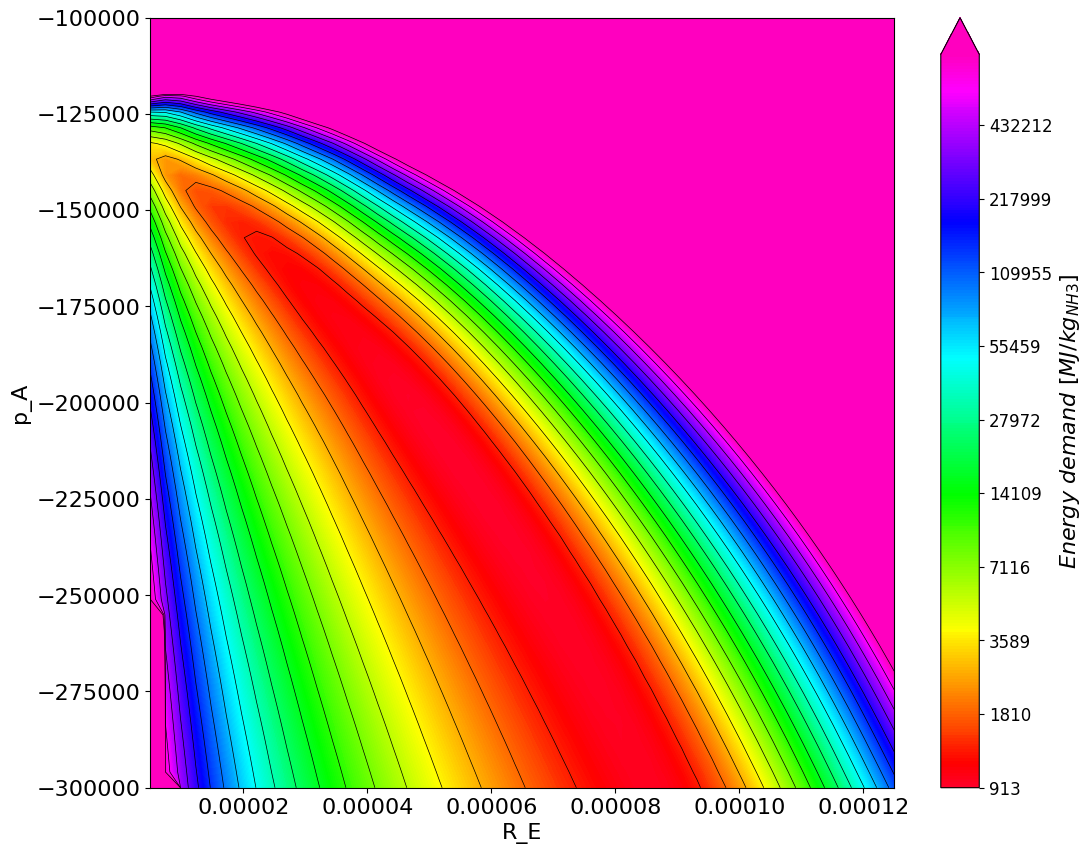

In [9]:
# Plot:
contour_levels = 20
title = ''
xlabel = key1
ylabel = key2

fig,ax=plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, contour_levels), colors='black', linewidths=0.5)
colorbar_title = '$Energy\ demand\ [MJ/kg_{' + gd.de.target_specie + '}]$'
cbar = fig.colorbar(cp, label=colorbar_title) # Add a colorbar to a plot
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
if use_log10:
    cbar.set_ticklabels([f'{10**tick:.0f}' for tick in ticks])  # Format as powers of 10
else:
    cbar.set_ticklabels([f'{tick:.1f}' for tick in ticks])
cbar.ax.tick_params(labelsize=12)  # Adjust font size
plt.show()

## Plot gradient descent search

Starting point: (R_E=1.7443360461243972e-05, p_A=-110717.70988315406)
Output in starting point:  5267570080028.6338


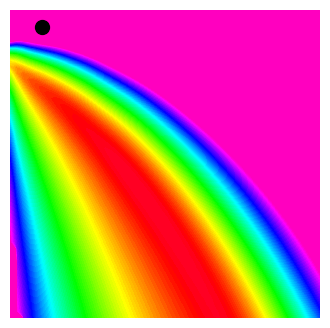

In [133]:
# Generate random starting_point:

start_point = gd.rand_point(ranges, padding=0.01)   # random point in ranges

print(f'Starting point: ({key1}={start_point[key1]}, {key2}={start_point[key2]})')
data, success = gd.evaluate(start_point, to_optimize, t_int=[0.0, 1.0], LSODA_timeout=10, Radau_timeout=0)
if not success:
    print(colored(f'Error, simulation failed', 'red'))
else:
    print(f'Output in starting point: {data[to_optimize]: .4f}')

# Plot:

fig,ax=plt.subplots(1, 1, figsize=(4, 4))
levels = np.linspace(vmin, vmax, 100)
ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.scatter(start_point[key1], start_point[key2], color='black', s=100, label='Starting point')
ax.axis('off')
plt.show()

In [134]:
start_point_copy = gd.de.copy(start_point)

datas, last_bests, elapsed_time = gd.gradient_descent(
    ranges=ranges, path='', to_optimize=to_optimize, start_point=start_point_copy,
    step_limit=100, first_step=0.01, min_step=1e-4, delta=1e-5,
    verbose=True, t_int=np.array([0.0, 1.0]), LSODA_timeout=10.0, Radau_timeout=0.0
)

0. step; last_best= 5.26573e+12; absolute_best= 5.26573e+12; step_size= 0.01000
	point   =(R_E= 1.744336e-05; p_A=-1.107177e+05; )
	output  =5546846.944343622; success=True; modifier=4.0; 
	gradient=(R_E=-0.0672; p_A= 0.9977; )
	change  =(R_E= 3.226602e-07; p_A=-7.981905e+03; )
1. step; last_best= 5.54685e+06; absolute_best= 5.54685e+06; step_size= 0.04000
	point   =(R_E= 1.776602e-05; p_A=-1.186996e+05; )
	output  =1426.093108776614; success=True; modifier=4.0; 
	gradient=(R_E= 0.0862; p_A= 0.9963; )
	change  =(R_E=-1.654406e-06; p_A=-3.188098e+04; )
2. step; last_best= 1.42603e+03; absolute_best= 1.42603e+03; step_size= 0.16000
	point   =(R_E= 1.611161e-05; p_A=-1.505806e+05; )
	output  =1687.926629957094; success=True; modifier=0.25; 
	gradient=(R_E=-0.9909; p_A=-0.1347; )
	change  =(R_E= 4.756268e-06; p_A= 1.077441e+03; )
3. step; last_best= 1.68793e+03; absolute_best= 1.42603e+03; step_size= 0.04000
	point   =(R_E= 2.086788e-05; p_A=-1.495032e+05; )
	output  =1323.1890709509278; s

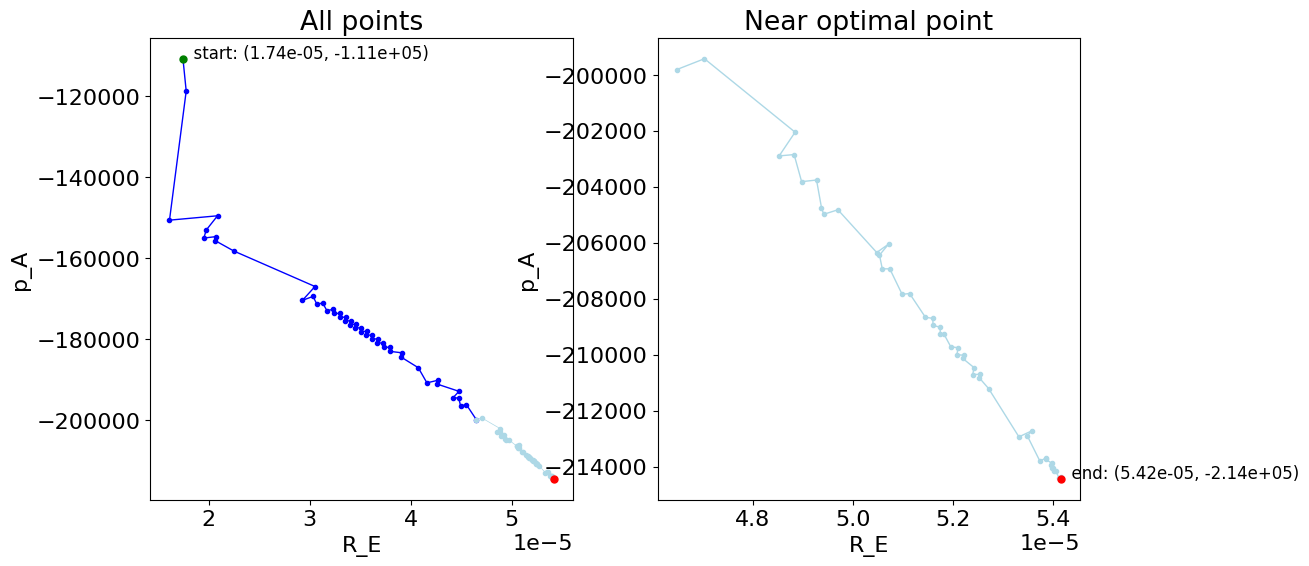

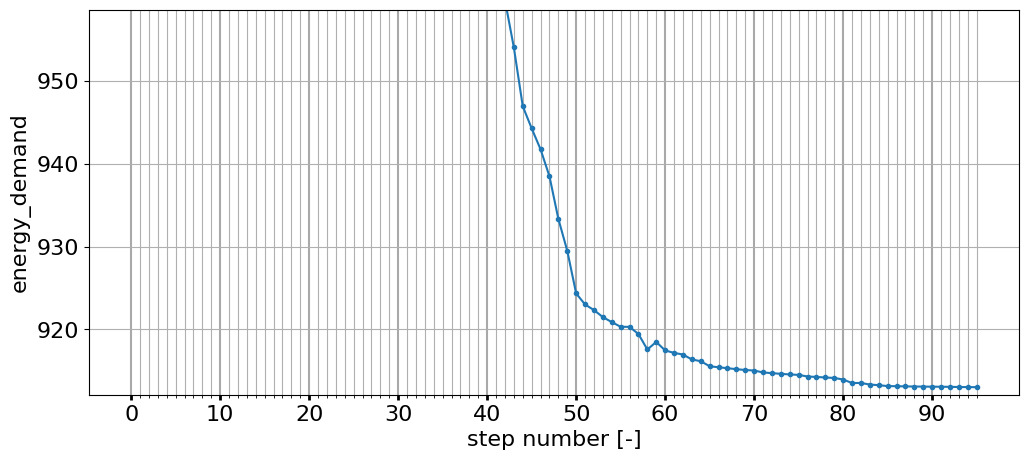

last output:  913.00


In [135]:
all_central_points = []
central_outputs = []
for points in datas:
    outputs = [data[to_optimize] for data in points]
    central_outputs.append(outputs[0])
    #central_outputs.append(min(outputs))
    all_central_points.append(points[0])
value1 = [data[key1] for data in all_central_points]
value2 = [data[key2] for data in all_central_points]
start = len(all_central_points) // 2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(value1[:start+1], value2[:start+1], '.-', color='blue', linewidth=1, zorder=1)
ax[0].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=0.5, zorder=1)
ax[1].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=1, zorder=1)
ax[0].scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax[0].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[1].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[0].text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax[1].text(value1[-1], value2[-1], f'  end: ({value1[-1]:.2e}, {value2[-1]:.2e})', fontsize=12)
ax[0].set_title('All points')
ax[1].set_title('Near optimal point')
ax[0].set_xlabel(key1)
ax[0].set_ylabel(key2)
ax[1].set_xlabel(key1)
ax[1].set_ylabel(key2)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(central_outputs[:])), central_outputs[:], '.-')
ax.set_ylim([0.999*min(central_outputs), 1.05*min(central_outputs)])
ax.set_xticks(range(0, len(central_outputs[:]), 10), minor=False)
ax.set_xticks(range(len(central_outputs[:])), minor=True)
ax.tick_params(which='major', axis='x', width=2, grid_color='darkgrey', grid_linewidth=1.5)
ax.set_xlabel('step number [-]')
ax.set_ylabel(to_optimize)
ax.grid(which='both')
#plt.yscale('log')
plt.show()
print(f'last output: {central_outputs[-1]: .2f}')

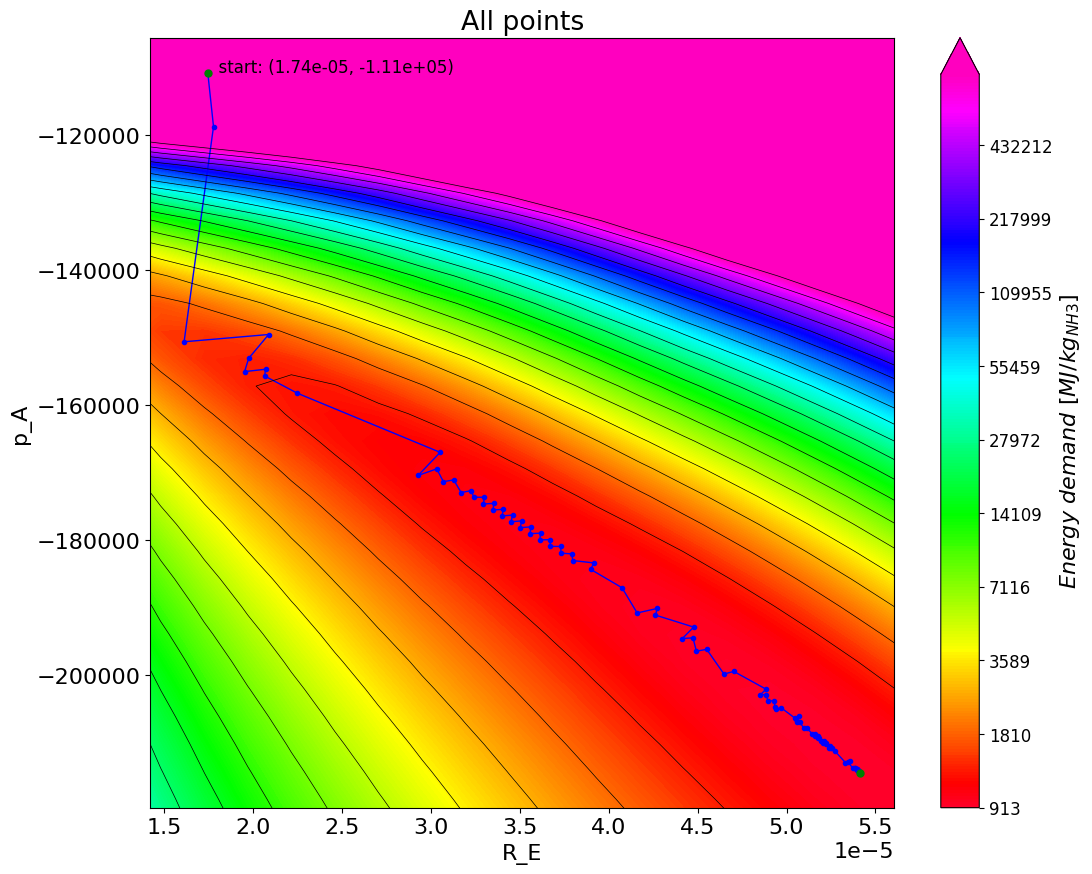

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
maxi = np.log10(max(central_outputs))
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=min(vmax, maxi), extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, contour_levels), colors='black', linewidths=0.5)
colorbar_title = '$Energy\ demand\ [MJ/kg_{' + gd.de.target_specie + '}]$'
cbar = fig.colorbar(cp, label=colorbar_title) # Add a colorbar to a plot

ax.plot(value1[:], value2[:], '.-', color='blue', linewidth=1, zorder=1)
ax.scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax.scatter([value1[-1]], [value2[-1]], color='green', zorder=2, s=25)   # optimal point
ax.text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax.set_title('All points')
ax.set_xlabel(key1)
ax.set_ylabel(key2)

range1 = max(value1) - min(value1)
range2 = max(value2) - min(value2)
range1 = [min(value1) - 0.05*range1, max(value1) + 0.05*range1]
range2 = [min(value2) - 0.05*range2, max(value2) + 0.05*range2]
ax.set_xlim(range1)
ax.set_ylim(range2)

ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
if use_log10:
    cbar.set_ticklabels([f'{10**tick:.0f}' for tick in ticks])  # Format as powers of 10
else:
    cbar.set_ticklabels([f'{tick:.1f}' for tick in ticks])
cbar.ax.tick_params(labelsize=12)  # Adjust font size
plt.show()